# Amazon Review Sentiment Analysis (Positive, Negative, Neutral)

In [33]:
pip install keras --upgrade

In [34]:
pip install transformers

In [35]:
import pandas as pd
import numpy as np
import re, string
from sklearn.model_selection import train_test_split

url = 'https://raw.githubusercontent.com/ravsssh/Amazon-Sentiment-Analysis/refs/heads/main/tweet.csv'

df = pd.read_csv(url, sep=",")

In [36]:
df

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


In [37]:
# First, check the original distribution of sentiment values
print("Original sentiment distribution:")
print(df['sentiment'].value_counts())

# Calculate the fraction needed to get approximately 5000 samples
sample_size = 5000
sample_fraction = sample_size / len(df)

# Perform stratified sampling
df_sample, _ = train_test_split(
    df,
    train_size=sample_fraction,
    stratify=df['sentiment'],
    random_state=42  # For reproducibility
)

# Make adjustments to get exactly 5000 rows if needed
if len(df_sample) != 5000:
    if len(df_sample) > 5000:
        # Remove excess rows
        df_sample = df_sample.sample(5000, random_state=42)
    else:
        # Add remaining rows
        remaining = df.drop(df_sample.index).sample(5000 - len(df_sample), random_state=42)
        df_sample = pd.concat([df_sample, remaining])

# Verify the sample size and distribution
print(f"\nSample size: {len(df_sample)}")
print("\nSampled sentiment distribution:")
print(df_sample['sentiment'].value_counts())

# Reset index
df_sample = df_sample.reset_index(drop=True)

# Display the first few rows
df_sample.head()

Original sentiment distribution:
sentiment
neutral     11118
positive     8582
negative     7781
Name: count, dtype: int64

Sample size: 5000

Sampled sentiment distribution:
sentiment
neutral     2023
positive    1561
negative    1416
Name: count, dtype: int64


,textID,text,selected_text,sentiment
0,85537b6837,i was right about the wave off,i was right about the wave off,neutral
1,ebda3686bc,i like this Dr. Seuss quote - ï¿½You know you`...,i like this Dr. Seuss quote - ï¿½You know you`...,positive
2,bdee06c65d,I had a super cool dream last night. asked me...,. Wooowww,positive
3,c336b00b07,_O_ASH I do too plus more happy mothers day Sw...,happy,positive
4,fa52ceb912,Major Fail. Since you asked,Fail.,negative


In [38]:
df_sample['text'] = df_sample['text'].astype(str) #convert text to string

#Remove punctuations, links, mentions and \r\n new line characters
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the # symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as & and $ present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text): # remove multiple spaces
    return re.sub("\s\s+" , " ", text)

In [39]:
texts_new = []
for t in df_sample.text:
    texts_new.append(remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(t)))))

In [40]:
df_sample['text_clean'] = texts_new
df_sample.head()

,textID,text,selected_text,sentiment,text_clean
0,85537b6837,i was right about the wave off,i was right about the wave off,neutral,i was right about the wave off
1,ebda3686bc,i like this Dr. Seuss quote - ï¿½You know you`...,i like this Dr. Seuss quote - ï¿½You know you`...,positive,i like this dr seuss quote you know youre in l...
2,bdee06c65d,I had a super cool dream last night. asked me...,. Wooowww,positive,i had a super cool dream last night asked me a...
3,c336b00b07,_O_ASH I do too plus more happy mothers day Sw...,happy,positive,oash i do too plus more happy mothers day sweety
4,fa52ceb912,Major Fail. Since you asked,Fail.,negative,major fail since you asked


In [41]:
df_sample['text_clean'] = df_sample['text_clean'].str.replace(' x000d', '')

In [42]:
df_sample['text_clean'][1:8].values

array(['i like this dr seuss quote you know youre in love when you cant fall asleep because reality is finally better than your dreams',
       'i had a super cool dream last night asked me and to be on her show wooowww hopes it will come true',
       'oash i do too plus more happy mothers day sweety',
       'major fail since you asked', 'sorry i can not reach either url',
       'im home yay unpacked everything now just got to wash it all',
       'facepalm hope the interview is a choice and not a forced thing'],
      dtype=object)

In [43]:
df_sample['label'] = df_sample['sentiment'].map({'neutral':0,'positive':1,'negative':2,})

In [44]:
df_sample

,textID,text,selected_text,sentiment,text_clean,label
0,85537b6837,i was right about the wave off,i was right about the wave off,neutral,i was right about the wave off,0
1,ebda3686bc,i like this Dr. Seuss quote - ï¿½You know you`...,i like this Dr. Seuss quote - ï¿½You know you`...,positive,i like this dr seuss quote you know youre in l...,1
2,bdee06c65d,I had a super cool dream last night. asked me...,. Wooowww,positive,i had a super cool dream last night asked me a...,1
3,c336b00b07,_O_ASH I do too plus more happy mothers day Sw...,happy,positive,oash i do too plus more happy mothers day sweety,1
4,fa52ceb912,Major Fail. Since you asked,Fail.,negative,major fail since you asked,2
...,...,...,...,...,...,...
4995,021e4d7fd7,See you on may 16!!,See you on may 16!!,neutral,see you on may 16,0
4996,78e5a52d15,gonna go outside with my daddy... gonna take a...,gonna go outside with my daddy... gonna take a...,neutral,gonna go outside with my daddy gonna take a ri...,0
4997,43cf7eb301,freeeeeeeeeeeeeeeezING **** im so excited to ...,freeeeeeeeeeeeeeeezING **** im so excited to s...,neutral,freeeeeeeeeeeeeeeezing im so excited to see yo...,0
4998,b937a442b0,How did your book signing go? If I lived the...,How did your book signing go? If I lived ther...,neutral,how did your book signing go if i lived there ...,0


In [45]:
df_sample = df_sample[['text','text_clean', 'label']]

In [46]:
df_sample

,text,text_clean,label
0,i was right about the wave off,i was right about the wave off,0
1,i like this Dr. Seuss quote - ï¿½You know you`...,i like this dr seuss quote you know youre in l...,1
2,I had a super cool dream last night. asked me...,i had a super cool dream last night asked me a...,1
3,_O_ASH I do too plus more happy mothers day Sw...,oash i do too plus more happy mothers day sweety,1
4,Major Fail. Since you asked,major fail since you asked,2
...,...,...,...
4995,See you on may 16!!,see you on may 16,0
4996,gonna go outside with my daddy... gonna take a...,gonna go outside with my daddy gonna take a ri...,0
4997,freeeeeeeeeeeeeeeezING **** im so excited to ...,freeeeeeeeeeeeeeeezing im so excited to see yo...,0
4998,How did your book signing go? If I lived the...,how did your book signing go if i lived there ...,0


In [47]:
x_train, x_rem, y_train, y_rem = train_test_split(
    df_sample['text_clean'].values,
    df_sample['label'].values,
    test_size=0.2,
    stratify=df_sample['label'].values,  # Add stratification
    random_state=42
)

x_val, x_test, y_val, y_test = train_test_split(
    x_rem,
    y_rem,
    test_size=0.5,  # This results in 10% test, 10% validation
    stratify=y_rem,  # Add stratification
    random_state=42
)

In [48]:
x_train

array(['oh darn lost another follower',
       'i have too much work to drink now but i do love afternoons in the pub',
       'good morning', ..., 'cant wait for the next twitter',
       'good news finally finished my easactive workout that has been paused for 6 hours bad news my resistance band is torn',
       'mak request me on bbm send all ur contact info everything didnt sync up from old phn i have ur tmail info haha dated'],
      dtype=object)

In [49]:
print(f"TRAINING DATA: {x_train.shape[0]}\nVALIDATION DATA: {x_val.shape[0]}\nTESTING DATA: {x_test.shape[0]}" )

TRAINING DATA: 4000
VALIDATION DATA: 500
TESTING DATA: 500


In [50]:
y_train

array([2, 0, 1, ..., 1, 0, 0])

In [51]:
y_train_le = y_train.copy()
y_valid_le = y_val.copy()
y_test_le = y_test.copy()

In [52]:
import tensorflow as tf
from tensorflow import keras
from keras import regularizers
from transformers import BertTokenizerFast
from transformers import TFBertModel
from transformers import RobertaTokenizerFast
from transformers import TFRobertaModel

# from sklearn import preprocessing

In [53]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [54]:
from sklearn import preprocessing

ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_val = ohe.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [55]:
y_train

array([[0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

In [56]:
print(f"TRAINING DATA: {x_train.shape[0]}\nVALIDATION DATA: {x_val.shape[0]}\nTESTING DATA: {x_test.shape[0]}" )

TRAINING DATA: 4000
VALIDATION DATA: 500
TESTING DATA: 500


In [57]:
MAX_WORDS = 5000
MAX_LEN = 200

In [58]:
def tokenize(data,max_len=MAX_LEN) :
    input_ids = []
    attention_masks = []
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(
            data[i],
            add_special_tokens=True,
            max_length=MAX_LEN,
            padding='max_length',
            return_attention_mask=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return np.array(input_ids),np.array(attention_masks)

In [59]:
import numpy as np

train_input_ids, train_attention_masks = tokenize(x_train, MAX_LEN)
val_input_ids, val_attention_masks = tokenize(x_val, MAX_LEN)
test_input_ids, test_attention_masks = tokenize(x_test, MAX_LEN)

In [60]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [61]:
def create_model(bert_model, max_len=MAX_LEN):

    ##params###
    # Use legacy Adam optimizer and learning_rate_decay_per_step instead of decay
    opt = tf.keras.optimizers.legacy.Adam(learning_rate=1e-5)
    loss = tf.keras.losses.CategoricalCrossentropy()
    accuracy = tf.keras.metrics.CategoricalAccuracy()

    input_ids = tf.keras.Input(shape=(max_len,),dtype='int32')

    attention_masks = tf.keras.Input(shape=(max_len,),dtype='int32')

    embeddings = bert_model([input_ids,attention_masks])[1]
    output = embeddings[:,]

    # Fix the Dense layer to match the number of classes (3 not 7)
    output = tf.keras.layers.Dense(3, activation="softmax")(output)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks], outputs = output)

    model.compile(opt, loss=loss, metrics=accuracy)

    return model

In [62]:
model = create_model(bert_model, MAX_LEN)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 200)]                0         []                            
                                                                                                  
 tf_bert_model_1 (TFBertMod  TFBaseModelOutputWithPooli   1094822   ['input_3[0][0]',             
 el)                         ngAndCrossAttentions(last_   40         'input_4[0][0]']             
                             hidden_state=(None, 200, 7                                           
                             68),                                                           

In [63]:
history_bert = model.fit([train_input_ids,train_attention_masks], y_train, validation_data=([val_input_ids,val_attention_masks], y_val), epochs=5, batch_size=32, verbose=2)

Epoch 1/5
125/125 - 175s - loss: 0.9178 - categorical_accuracy: 0.5573 - val_loss: 0.7254 - val_categorical_accuracy: 0.6700 - 175s/epoch - 1s/step
Epoch 2/5
125/125 - 162s - loss: 0.5987 - categorical_accuracy: 0.7480 - val_loss: 0.6801 - val_categorical_accuracy: 0.7160 - 162s/epoch - 1s/step
Epoch 3/5
125/125 - 162s - loss: 0.4486 - categorical_accuracy: 0.8248 - val_loss: 0.7022 - val_categorical_accuracy: 0.7200 - 162s/epoch - 1s/step
Epoch 4/5
125/125 - 159s - loss: 0.3209 - categorical_accuracy: 0.8777 - val_loss: 0.7759 - val_categorical_accuracy: 0.7120 - 159s/epoch - 1s/step
Epoch 5/5
125/125 - 162s - loss: 0.2190 - categorical_accuracy: 0.9237 - val_loss: 0.8713 - val_categorical_accuracy: 0.7260 - 162s/epoch - 1s/step


# Modelling

In [64]:
for i, layer in enumerate(model.layers):
    print(i, layer.name)

0 input_3
1 input_4
2 tf_bert_model_1
3 tf.__operators__.getitem_1
4 dense_1


In [65]:
# Using the layer index (3 based on your model summary)
cls_layer_model = tf.keras.models.Model(
    inputs=model.inputs,
    outputs=model.layers[3].output  # Index 3 corresponds to tf.__operators__.getitem
)


In [66]:
cls_x_train = cls_layer_model.predict([train_input_ids,train_attention_masks])
cls_x_val = cls_layer_model.predict([val_input_ids, val_attention_masks])
cls_x_test = cls_layer_model.predict([test_input_ids, test_attention_masks])

16/16 [==============================] - 7s 431ms/step


In [71]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


rfmodel = RandomForestClassifier(
    max_features = 'sqrt',
    random_state=42,
    bootstrap = False,
    )

param_grid = {
    'n_estimators': [ 50, 100],
    'max_depth': [None, 10,],
}

grid_search = GridSearchCV(rfmodel, param_grid, cv=3, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(cls_x_train, y_train_le)
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Hyperparameters: {'max_depth': 10, 'n_estimators': 50}



Validation Accuracy (Tuned RF): 0.7180

Classification Report (Tuned RF - Validation):
              precision    recall  f1-score   support

           0       0.66      0.77      0.71       202
           1       0.81      0.76      0.79       156
           2       0.71      0.60      0.65       142

    accuracy                           0.72       500
   macro avg       0.73      0.71      0.72       500
weighted avg       0.72      0.72      0.72       500


Test Accuracy (Tuned RF): 0.7300

Classification Report (Tuned RF - Test):
              precision    recall  f1-score   support

           0       0.67      0.73      0.70       203
           1       0.84      0.72      0.78       156
           2       0.73      0.74      0.73       141

    accuracy                           0.73       500
   macro avg       0.74      0.73      0.74       500
weighted avg       0.74      0.73      0.73       500



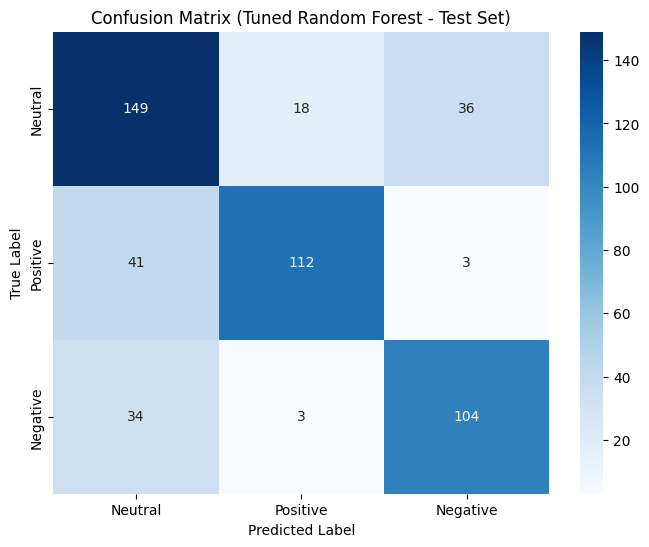

In [72]:
best_rf_model = RandomForestClassifier(**best_params, random_state=42)
best_rf_model.fit(cls_x_train, y_train_le)

y_valid_pred = best_rf_model.predict(cls_x_val)

# Evaluate performance on validation set
val_accuracy = accuracy_score(y_valid_le, y_valid_pred)
print(f"\nValidation Accuracy (Tuned RF): {val_accuracy:.4f}")
print("\nClassification Report (Tuned RF - Validation):")
print(classification_report(y_valid_le, y_valid_pred))

# Predictions on test set
y_test_pred = best_rf_model.predict(cls_x_test)

# Evaluate performance on test set
test_accuracy = accuracy_score(y_test_le, y_test_pred)
print(f"\nTest Accuracy (Tuned RF): {test_accuracy:.4f}")
print("\nClassification Report (Tuned RF - Test):")
print(classification_report(y_test_le, y_test_pred))

# Visualize Confusion Matrix for Test Set
cm = confusion_matrix(y_test_le, y_test_pred)
class_labels = ['Neutral', 'Positive', 'Negative']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Tuned Random Forest - Test Set)')
plt.show()

In [73]:
# 1. Prepare the example sentences
example_sentences = [
    "This product is amazing! I love it.",
    "The service was terrible, very disappointed.",
    "It's okay, not great but not bad either.",
    "Highly recommend this item.",
    "Worst experience ever."
]

# 2. Clean and preprocess the example sentences
# You need to use the same cleaning functions as before
def strip_all_entities(text):
    text = text.replace('\r', '').replace('\n', ' ').replace('\n', ' ').lower()
    text = re.sub(r"(?:\@|https?\://)\S+", "", text)
    text = re.sub(r'[^\x00-\x7f]',r'', text)
    banned_list= string.punctuation + 'Ã'+'±'+'ã'+'¼'+'â'+'»'+'§'
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    return text

def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet))
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet))
    return new_tweet2

def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

cleaned_examples = []
for sentence in example_sentences:
    cleaned_sentence = remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(sentence))))
    cleaned_examples.append(cleaned_sentence)

# 3. Tokenize and get BERT embeddings for the example sentences
# Use the same tokenizer and BERT model as before
# Assuming 'tokenizer' and 'cls_layer_model' are already defined and loaded

example_input_ids, example_attention_masks = tokenize(cleaned_examples, MAX_LEN)
example_cls_embeddings = cls_layer_model.predict([example_input_ids, example_attention_masks])

# 4. Make predictions with the Random Forest model
# Assuming 'best_rf_model' is your trained Random Forest model
example_predictions = best_rf_model.predict(example_cls_embeddings)

# 5. Interpret the predictions
sentiment_map = {0: 'neutral', 1: 'positive', 2: 'negative'}
predicted_sentiments = [sentiment_map[pred] for pred in example_predictions]

# Print the results
print("Example Sentences and Predicted Sentiments:")
for original, predicted in zip(example_sentences, predicted_sentiments):
    print(f"Review: '{original}' -> Predicted Sentiment: {predicted}")

1/1 [==============================] - 0s 135ms/step
Example Sentences and Predicted Sentiments:
Review: 'This product is amazing! I love it.' -> Predicted Sentiment: positive
Review: 'The service was terrible, very disappointed.' -> Predicted Sentiment: negative
Review: 'It's okay, not great but not bad either.' -> Predicted Sentiment: neutral
Review: 'Highly recommend this item.' -> Predicted Sentiment: positive
Review: 'Worst experience ever.' -> Predicted Sentiment: negative


In [74]:
pip install xgboost

In [78]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    random_state=42)

param_grid_xgb = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1]
}

grid_search_xgb = GridSearchCV(estimator=xgb_model, param_grid=param_grid_xgb, cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV on your training data
# XGBoost requires integer labels when not using one-hot encoding directly in the model
# Since y_train_le are already integers, we can use them directly
grid_search_xgb.fit(cls_x_train, y_train_le)

# Get the best hyperparameters
best_params_xgb = grid_search_xgb.best_params_
print(f"Best XGBoost Hyperparameters: {best_params_xgb}")

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best XGBoost Hyperparameters: {'learning_rate': 0.1, 'n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:25:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Validation Accuracy (Tuned XGBoost): 0.7100

Classification Report (Tuned XGBoost - Validation):
              precision    recall  f1-score   support

           0       0.65      0.75      0.70       202
           1       0.80      0.76      0.78       156
           2       0.71      0.61      0.65       142

    accuracy                           0.71       500
   macro avg       0.72      0.70      0.71       500
weighted avg       0.71      0.71      0.71       500


Test Accuracy (Tuned XGBoost): 0.7340

Classification Report (Tuned XGBoost - Test):
              precision    recall  f1-score   support

           0       0.67      0.75      0.71       203
           1       0.85      0.72      0.78       156
           2       0.73      0.72      0.73       141

    accuracy                           0.73       500
   macro avg       0.75      0.73      0.74       500
weighted avg       0.74      0.73      0.74       500



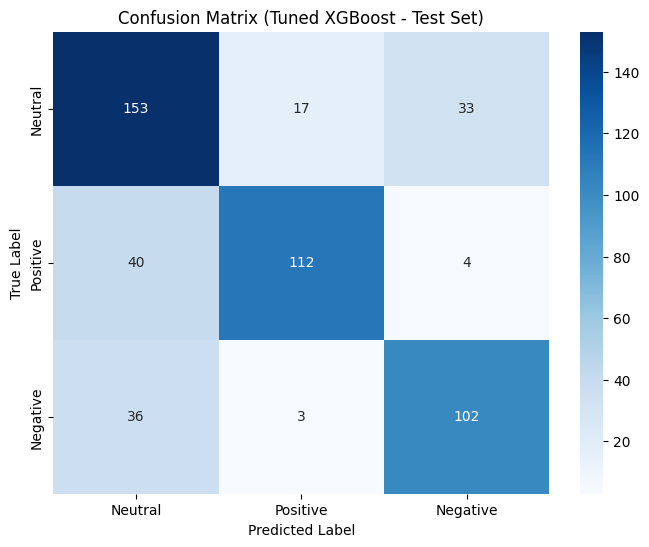

In [79]:
best_xgb_model = XGBClassifier(**best_params_xgb, random_state=42, use_label_encoder=False, eval_metric='mlogloss')
best_xgb_model.fit(cls_x_train, y_train_le)

# 5. Evaluate the model
# Predictions on validation set
y_valid_pred_xgb = best_xgb_model.predict(cls_x_val)

# Evaluate performance on validation set
val_accuracy_xgb = accuracy_score(y_valid_le, y_valid_pred_xgb)
print(f"\nValidation Accuracy (Tuned XGBoost): {val_accuracy_xgb:.4f}")
print("\nClassification Report (Tuned XGBoost - Validation):")
print(classification_report(y_valid_le, y_valid_pred_xgb))

# Predictions on test set
y_test_pred_xgb = best_xgb_model.predict(cls_x_test)

# Evaluate performance on test set
test_accuracy_xgb = accuracy_score(y_test_le, y_test_pred_xgb)
print(f"\nTest Accuracy (Tuned XGBoost): {test_accuracy_xgb:.4f}")
print("\nClassification Report (Tuned XGBoost - Test):")
print(classification_report(y_test_le, y_test_pred_xgb))

# Visualize Confusion Matrix for Test Set
cm_xgb = confusion_matrix(y_test_le, y_test_pred_xgb)
class_labels = ['Neutral', 'Positive', 'Negative'] # Assuming 0: Neutral, 1: Positive, 2: Negative

plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Tuned XGBoost - Test Set)')
plt.show()

In [80]:
# 6. Test with example sentences
# Use the same example sentences as before
example_sentences = [
    "This product is amazing! I love it.",
    "The service was terrible, very disappointed.",
    "It's okay, not great but not bad either.",
    "Highly recommend this item.",
    "Worst experience ever."
]

# Clean and preprocess the example sentences (using the same functions)
cleaned_examples = []
for sentence in example_sentences:
    cleaned_sentence = remove_mult_spaces(filter_chars(clean_hashtags(strip_all_entities(sentence))))
    cleaned_examples.append(cleaned_sentence)

# Tokenize and get BERT embeddings for the example sentences (using the same functions)
example_input_ids, example_attention_masks = tokenize(cleaned_examples, MAX_LEN)
example_cls_embeddings = cls_layer_model.predict([example_input_ids, example_attention_masks])

# Make predictions with the XGBoost model
example_predictions_xgb = best_xgb_model.predict(example_cls_embeddings)

# Interpret the predictions
sentiment_map = {0: 'neutral', 1: 'positive', 2: 'negative'} # Ensure this mapping matches your integer labels
predicted_sentiments_xgb = [sentiment_map[pred] for pred in example_predictions_xgb]

# Print the results
print("\nExample Sentences and Predicted Sentiments (XGBoost):")
for original, predicted in zip(example_sentences, predicted_sentiments_xgb):
    print(f"Review: '{original}' -> Predicted Sentiment: {predicted}")

1/1 [==============================] - 0s 134ms/step

Example Sentences and Predicted Sentiments (XGBoost):
Review: 'This product is amazing! I love it.' -> Predicted Sentiment: positive
Review: 'The service was terrible, very disappointed.' -> Predicted Sentiment: negative
Review: 'It's okay, not great but not bad either.' -> Predicted Sentiment: neutral
Review: 'Highly recommend this item.' -> Predicted Sentiment: positive
Review: 'Worst experience ever.' -> Predicted Sentiment: negative
